Repositório: https://github.com/mdrs-thiago/PUC_FuzzyLogic

In [1]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import math
import pandas as pd
from deap import base, creator, tools, algorithms
import logging
import random
import numpy as np
import sys
from typing import List, Tuple
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# pacotes personalizados
import util
from class_manipulate_data import ManipulateData
from class_control_panel import ControlPanel

In [2]:
# region: parâmetros necessários para uso do logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
console_format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
console_handler = logging.StreamHandler()
console_handler.setFormatter(console_format)
console_handler.setLevel(logging.INFO)
logger.addHandler(console_handler)
# endregion

logger.info(util.init())

__main__ - INFO - Módulo util importado com sucesso.


In [3]:
# tamanho da região de interesse (RUL abaixo de LENGHT_ROI)
LENGHT_ROI = 125
manipulate_data = ManipulateData()
path_preprocessing_output = manipulate_data.get_path_preprocessing_output()


control_panel = ControlPanel(rolling_mean=False,
                                 window_mean=None,
                                 use_validation_data=False,
                                 number_units_validation=None,
                                 use_optuna=True,
                                 use_savgol_filter=False,
                                 use_roi=True)

In [4]:
# entradas selecionadas pelo algoritmo genético
input_model = ["sensor_9", "sensor_11", "sensor_13", "sensor_7", "time", "sensor_12"]

output_model = ['RUL']

equipment_name = 'FD001'

In [5]:
logger.info("Lendo os dados de treino.")

path_dataset_train = \
    str(path_preprocessing_output.joinpath(f"train_{equipment_name}.parquet"))

df_train = pd.read_parquet(path_dataset_train)
df_train = control_panel.apply_roi(df_train, output_model[0], LENGHT_ROI)

logger.info("Lendo os dados de teste.")

path_dataset_test = \
    str(path_preprocessing_output.joinpath(f"test_{equipment_name}.parquet"))

df_test = pd.read_parquet(path_dataset_test)
df_test = control_panel.apply_roi(df_test, output_model[0], LENGHT_ROI)

__main__ - INFO - Lendo os dados de treino.
__main__ - INFO - Lendo os dados de teste.


In [6]:
df_train = df_train[input_model + output_model].copy()

df_test = df_test[input_model + output_model].copy()

In [7]:
var_linguisticas = []
for input in input_model:
    min_train = df_train[input].min()
    min_test = df_test[input].min()
    if min_test < min_train:
        min_r = min_test
    else:
        min_r = min_train

    max_train = df_train[input].max()
    max_test = df_test[input].max()
    if max_test < max_train:
        max_r = max_train
    else:
        max_r = max_test
    aux = {}
    aux["name"] = input
    aux["min"] = math.floor(min_r) - 1
    aux["max"] = math.ceil(max_r) + 1
    aux["step"] = 0.01
    var_linguisticas.append(aux)

In [8]:
var_linguisticas

[{'name': 'sensor_9', 'min': 9020, 'max': 9246, 'step': 0.01},
 {'name': 'sensor_11', 'min': 45, 'max': 50, 'step': 0.01},
 {'name': 'sensor_13', 'min': 2386, 'max': 2390, 'step': 0.01},
 {'name': 'sensor_7', 'min': 548, 'max': 558, 'step': 0.01},
 {'name': 'time', 'min': 0, 'max': 363, 'step': 0.01},
 {'name': 'sensor_12', 'min': 517, 'max': 525, 'step': 0.01}]

## Criando o Sistema de Inferência Fuzzy com Python

Diferentemente de Redes Neurais e diferentes áreas de Machine Learning, não existe uma biblioteca tão popular para Sistemas de Inferência Fuzzy.

Nesta aula, usaremos uma biblioteca chamada **scikit fuzzy**

Seguiremos o mesmo padrão que usamos nas aulas teóricas:

1. Definição das variáveis linguísticas

2. Definição dos conjuntos fuzzy

3. Definição das regras de inferência

4. Definição de outros parâmetros do sistema (defuzzificação, agregação, etc)

c:\Users\marce\Documentos\python_venv\venvFuzzyTurbofan\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\Users\marce\Documentos\python_venv\venvFuzzyTurbofan\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


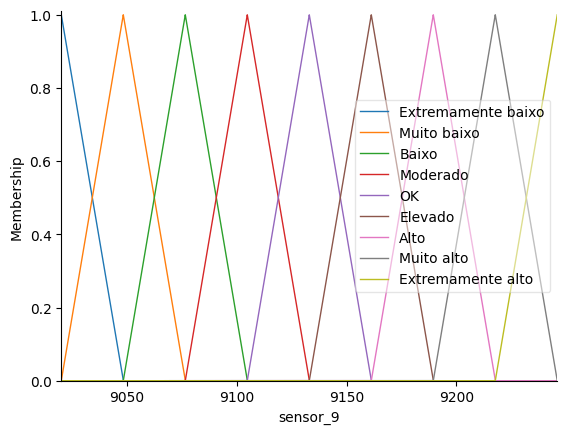

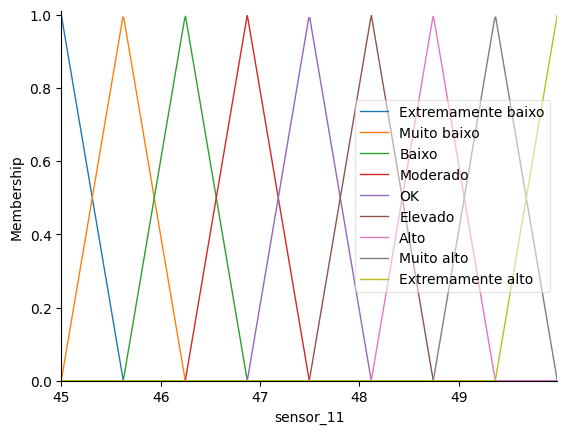

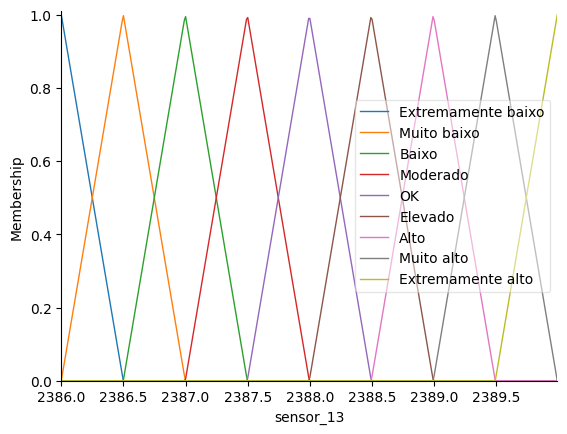

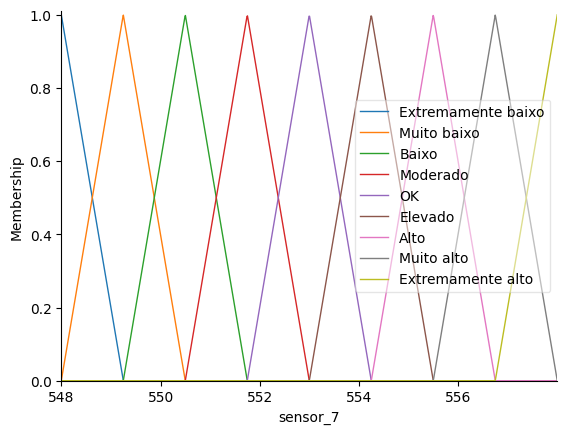

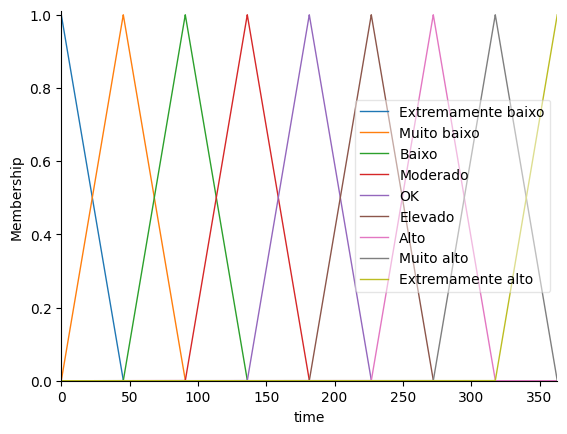

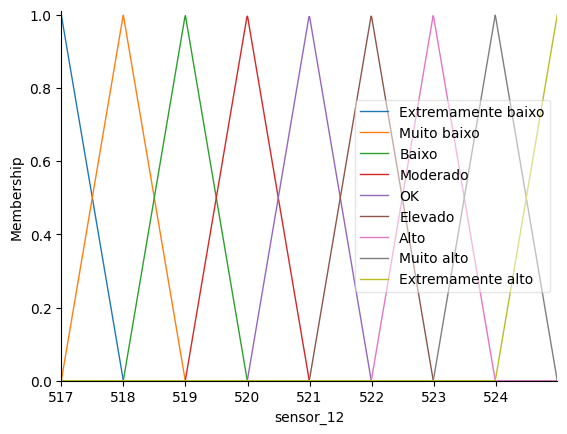

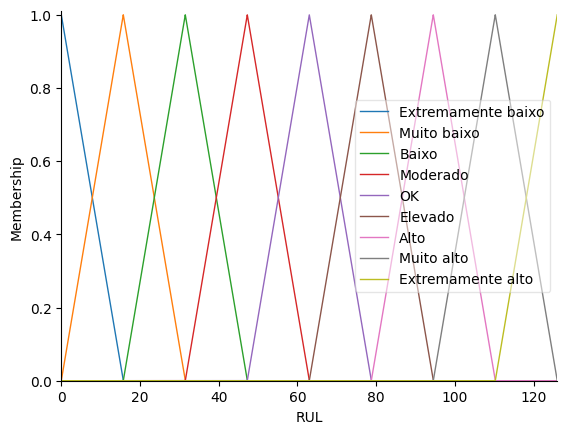

In [9]:
# Definimos o universo de discurso e o nome das variáveis linguísticas.
for var in var_linguisticas:
    var["antecedente"] = ctrl.Antecedent(np.arange(var["min"], var["max"], var["step"]), var["name"])
    var["antecedente"].automf(9, names=["Extremamente baixo",'Muito baixo','Baixo','Moderado', 'OK','Elevado', 'Alto', 'Muito alto', "Extremamente alto"])
    var["antecedente"].view()
# sensor_9 = 
# sensor_11 = ctrl.Antecedent(np.arange(46, 49, 0.01), 'sensor_11')
# sensor_13 = ctrl.Antecedent(np.arange(2387, 2389, 0.01), 'sensor_13')
# sensor_7 = ctrl.Antecedent(np.arange(549, 557, 0.01), 'sensor_7')
# time = ctrl.Antecedent(np.arange(0, 363.0, 1), 'time')
# sensor_12 = ctrl.Antecedent(np.arange(518, 524, 0.01), 'sensor_12')


# Para o consequente, podemos também definir o método de defuzzificação que será utilizado.
RUL = ctrl.Consequent(np.arange(math.floor(df_train[output_model].values.min()),
                                math.ceil(df_train[output_model].values.max()) + 1,
                                0.01),
                                output_model[0],
                                defuzzify_method='centroid')
RUL.automf(9, names=["Extremamente baixo",'Muito baixo','Baixo','Moderado', 'OK','Elevado', 'Alto', 'Muito alto', "Extremamente alto"])
RUL.view()

# Extração de regras

In [10]:
def manter_regras_com_maior_DR_j(regras):
    antecedentes_para_regras = {}
    
    # Passo 1: Criar um dicionário mapeando antecedentes para as regras com consequentes diferentes
    for regra in regras:
        antecedentes = tuple(regra['antecedentes'])
        consequente = regra['consequente']
        if antecedentes not in antecedentes_para_regras:
            antecedentes_para_regras[antecedentes] = {'regras': [regra], 'maior_DR_j': regra['DR_j']}
        else:
            antecedentes_para_regras[antecedentes]['regras'].append(regra)
            if regra['DR_j'] > antecedentes_para_regras[antecedentes]['maior_DR_j']:
                antecedentes_para_regras[antecedentes]['maior_DR_j'] = regra['DR_j']
    
    # Passo 2: Criar uma nova lista de regras com os maiores DR_j
    novas_regras = []
    for antecedentes, info in antecedentes_para_regras.items():
        maior_DR_j = info['maior_DR_j']
        regras_com_maior_DR_j = [regra for regra in info['regras'] if regra['DR_j'] == maior_DR_j]
        novas_regras.extend(regras_com_maior_DR_j)
    
    return novas_regras

In [11]:
regras = []
for indice, data in df_train.iterrows():
    DR_j = 1
    regra = {}
    # antecedente
    regra["antecedentes"] = []
    for var in var_linguisticas:
        valor = data[var["name"]]
        grau_max = 0
        conj_max = None
        for conjunto in var["antecedente"].terms:
            grau_pertinencia = fuzz.interp_membership(var["antecedente"].universe, var["antecedente"][conjunto].mf, valor)
            if grau_pertinencia > grau_max:
                grau_max = grau_pertinencia
                conj_max = conjunto
        DR_j = DR_j * grau_max
        
        regra["antecedentes"].append(var["antecedente"][conj_max])
    
    # consequente
    valor = data["RUL"]
    grau_max = 0
    conj_max = None
    for conjunto in RUL.terms:
        grau_pertinencia = fuzz.interp_membership(RUL.universe, RUL[conjunto].mf, valor)
        if grau_pertinencia > grau_max:
            grau_max = grau_pertinencia
            conj_max = conjunto
    DR_j = DR_j * grau_max
    regra["DR_j"] = DR_j
    regra["consequente"] = RUL[conj_max]
    regras.append(regra)

In [12]:
len(regras)

20631

In [13]:
df_train.shape

(20631, 7)

In [14]:
novas_regras = manter_regras_com_maior_DR_j(regras)

In [15]:
len(novas_regras)

599

In [16]:
ctrl_rule = []
# Combine os antecedentes usando o operador E ("&")
for regra in novas_regras:
    antecedentes = regra["antecedentes"]
    consequente = regra["consequente"]
    regra_aux = antecedentes[0]
    for antecedente in antecedentes[1:]:
        regra_aux = regra_aux & antecedente

    # Combine o antecedente com o consequente
    # regra_final = regra >> consequente

    # Adicione a regra ao controlador (se necessário)
    ctrl_rule.append(ctrl.Rule(regra_aux, consequente))

In [17]:
len(ctrl_rule)

599

# System

In [18]:
# Criando o sistema de controle
sistema_controle = ctrl.ControlSystem(ctrl_rule)
controle = ctrl.ControlSystemSimulation(sistema_controle)

In [19]:
data = df_train.iloc[0]

In [20]:
data

sensor_9     9046.19
sensor_11      47.47
sensor_13    2388.02
sensor_7      554.36
time            1.00
sensor_12     521.66
RUL           125.00
Name: 0, dtype: float64

In [21]:
# Definindo as entradas de temperatura e umidade
controle.input['sensor_9'] = 9046.19
controle.input['sensor_11'] = 47.47
controle.input['sensor_13'] = 2388.02
controle.input['sensor_7'] = 554.36
controle.input['time'] =  1.00
controle.input['sensor_12'] = 521.66

In [22]:
# Realizando a inferência
controle.compute()

# Obtendo a saída
print("RUL", controle.output['RUL'])

RUL 119.46142363058988


In [23]:
pred_rul = []
for indice, data in df_train.iterrows():
    DR_j = 1
    regra = {}
    # antecedente
    regra["antecedentes"] = []
    for var in var_linguisticas:
        valor = data[var["name"]]
        controle.input[var["name"]] = valor
    controle.compute()
    # Obtendo a saída
    pred_rul.append(controle.output['RUL'])

In [24]:
def root_mean_squared_error(y_true: pd.Series, y_pred: pd.Series) -> float:
    """Faz o cálculo do RMSE.

    Parameters
    ----------
    y_true : pd.Series
        Valor real.
    y_pred : pd.Series
        Valor predito pelo modelo.

    Returns
    -------
    float
        Valor do RMSE.
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [25]:
rmse = root_mean_squared_error(df_train["RUL"].values, pred_rul)
rmse

23.499174998504518

In [26]:
mae = mean_absolute_error(df_train["RUL"].values, pred_rul)
mae

18.915331827662584

In [27]:
pred_rul = []
for indice, data in df_test.iterrows():
    DR_j = 1
    regra = {}
    # antecedente
    regra["antecedentes"] = []
    for var in var_linguisticas:
        valor = data[var["name"]]
        controle.input[var["name"]] = valor
    controle.compute()
    # Obtendo a saída
    pred_rul.append(controle.output['RUL'])

In [28]:
rmse = root_mean_squared_error(df_test["RUL"].values, pred_rul)
rmse

25.181203169898858

In [29]:
mae = mean_absolute_error(df_test["RUL"].values, pred_rul)
mae

20.615803975010465